<a href="https://colab.research.google.com/github/aymenchibouti/newversion/blob/master/claude_enhanced_cuml_res.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
GPU-ACCELERATED ENHANCED MACHINE LEARNING PIPELINE FOR DROPOUT PREDICTION
========================================================================

This pipeline uses cuML (RAPIDS) for GPU-accelerated machine learning:
- GPU-accelerated preprocessing and model training
- Automatic fallback to CPU if GPU unavailable
- Significantly faster processing for large datasets
- Full compatibility with scikit-learn API
- Memory-efficient GPU operations

Requirements:
- NVIDIA GPU with CUDA support
- RAPIDS cuML: conda install -c rapidsai -c nvidia -c conda-forge cuml
- Alternative: pip install cuml-cu11 (for CUDA 11)

Author: Enhanced cuML Pipeline
Date: 2024
"""

import os
import sys
import time
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# GPU availability check
GPU_AVAILABLE = False
CUML_AVAILABLE = False

try:
    import cupy as cp
    import cuml
    from cuml import __version__ as cuml_version

    # Check GPU availability
    try:
        cp.cuda.Device().use()
        GPU_AVAILABLE = True
        CUML_AVAILABLE = True
        print(f"🚀 GPU detected! Using cuML version: {cuml_version}")
        print(f"🎯 GPU Memory: {cp.cuda.Device().mem_info[1] / 1024**3:.1f} GB total")
    except Exception as e:
        print(f"⚠️ GPU not available: {e}")
        GPU_AVAILABLE = False

except ImportError:
    print("⚠️ cuML not installed. Install with: conda install -c rapidsai cuml")
    CUML_AVAILABLE = False

# Import cuML or fallback to scikit-learn
if CUML_AVAILABLE and GPU_AVAILABLE:
    print("📊 Using GPU-accelerated cuML")

    # cuML imports
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import StandardScaler, MinMaxScaler
    from cuml.ensemble import RandomForestClassifier
    from cuml.linear_model import LogisticRegression
    from cuml.svm import SVC
    from cuml.neighbors import NearestNeighbors
    from cuml.decomposition import PCA
    from cuml.metrics import accuracy_score, confusion_matrix

    # Still need some CPU libraries
    from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
    from sklearn.ensemble import GradientBoostingClassifier  # Not in cuML yet
    import cupy as cp

    # GPU memory management
    def clear_gpu_memory():
        """Clear GPU memory"""
        if GPU_AVAILABLE:
            cp.get_default_memory_pool().free_all_blocks()

    def to_gpu(data):
        """Convert data to GPU if available"""
        if GPU_AVAILABLE and isinstance(data, np.ndarray):
            return cp.asarray(data)
        return data

    def to_cpu(data):
        """Convert data back to CPU"""
        if GPU_AVAILABLE and hasattr(data, 'get'):
            return cp.asnumpy(data)
        return data

else:
    print("📊 Using CPU-based scikit-learn")

    # Fallback to scikit-learn
    from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.neighbors import NearestNeighbors
    from sklearn.decomposition import PCA
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                               confusion_matrix, roc_auc_score, roc_curve)

    # Dummy functions for compatibility
    def clear_gpu_memory():
        pass

    def to_gpu(data):
        return data

    def to_cpu(data):
        return data

# Common imports
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import lightgbm as lgb
import joblib
import pickle

# For VAE (TensorFlow will handle GPU automatically)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True

    # Configure TensorFlow for GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"🎮 TensorFlow will use {len(gpus)} GPU(s) for VAE")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")

except ImportError:
    print("⚠️ TensorFlow not available for VAE")
    TF_AVAILABLE = False

class GPUAcceleratedMLPipeline:
    """GPU-Accelerated ML Pipeline using cuML"""

    def __init__(self, data_path='model1_210_features_spliting.csv', output_dir='cuml_results'):
        self.data_path = data_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Initialize attributes
        self.data = None
        self.X = None
        self.y = None
        self.feature_names = None
        self.scaler = StandardScaler()
        self.results = {}
        self.best_model = None
        self.best_score = 0

        # GPU settings
        self.use_gpu = GPU_AVAILABLE and CUML_AVAILABLE
        self.batch_size = 10000 if self.use_gpu else 1000  # Larger batches for GPU

        # Create subdirectories
        (self.output_dir / 'models').mkdir(exist_ok=True)
        (self.output_dir / 'plots').mkdir(exist_ok=True)
        (self.output_dir / 'reports').mkdir(exist_ok=True)

        print(f"🚀 GPU-Accelerated ML Pipeline initialized")
        print(f"💻 Using: {'cuML (GPU)' if self.use_gpu else 'scikit-learn (CPU)'}")
        print(f"📁 Output directory: {self.output_dir.absolute()}")

    def load_and_explore_data(self):
        """Load and perform GPU-accelerated data exploration"""
        print("\n" + "="*60)
        print("📊 GPU-ACCELERATED DATA LOADING AND EXPLORATION")
        print("="*60)

        start_time = time.time()

        # Load data
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Data file not found: {self.data_path}")

        print(f"Loading data from: {self.data_path}")

        # Use cuDF for GPU-accelerated pandas operations if available
        try:
            if self.use_gpu:
                import cudf
                self.data = cudf.read_csv(self.data_path)
                print("✅ Using cuDF (GPU) for data loading")
            else:
                self.data = pd.read_csv(self.data_path)
                print("✅ Using pandas (CPU) for data loading")
        except ImportError:
            self.data = pd.read_csv(self.data_path)
            print("✅ Using pandas (CPU) for data loading")

        load_time = time.time() - start_time
        print(f"⏱️ Data loading time: {load_time:.2f} seconds")

        # Basic info
        print(f"📊 Dataset shape: {self.data.shape}")
        print(f"💾 Memory usage: {self.data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Remove non-feature columns
        cols_to_drop = ['username', 'course_id', 'enrollment_id']
        existing_cols = [col for col in cols_to_drop if col in self.data.columns]
        if existing_cols:
            self.data = self.data.drop(columns=existing_cols)
            print(f"🗑️ Removed columns: {existing_cols}")

        # Handle missing values (GPU-accelerated)
        missing_before = self.data.isnull().sum().sum()
        if missing_before > 0:
            print(f"🔧 Missing values found: {missing_before}")
            self.data = self.data.fillna(0)
            print("✅ Missing values filled with 0")

        # Verify target column
        if 'dropout' not in self.data.columns:
            raise KeyError("Target column 'dropout' not found")

        # Prepare features and target
        self.X = self.data.drop(columns=['dropout'])
        self.y = self.data['dropout']

        # Convert to CPU arrays for compatibility if needed
        if hasattr(self.X, 'to_pandas'):  # cuDF
            self.feature_names = self.X.columns.to_pandas().tolist()
            X_cpu = self.X.to_pandas().values
            y_cpu = self.y.to_pandas().values
        else:  # pandas
            self.feature_names = self.X.columns.tolist()
            X_cpu = self.X.values
            y_cpu = self.y.values

        # Store both GPU and CPU versions
        self.X_cpu = X_cpu
        self.y_cpu = y_cpu
        self.X_gpu = to_gpu(X_cpu) if self.use_gpu else X_cpu
        self.y_gpu = to_gpu(y_cpu) if self.use_gpu else y_cpu

        # Target distribution analysis
        if hasattr(self.y, 'value_counts'):
            target_counts = self.y.value_counts()
        else:
            unique, counts = np.unique(y_cpu, return_counts=True)
            target_counts = dict(zip(unique, counts))

        target_pct = {k: v/sum(target_counts.values())*100 for k, v in target_counts.items()}

        print(f"\n🎯 Target distribution:")
        print(f"   No dropout (0): {target_counts.get(0, 0):,} ({target_pct.get(0, 0):.1f}%)")
        print(f"   Dropout (1): {target_counts.get(1, 0):,} ({target_pct.get(1, 0):.1f}%)")

        if target_counts.get(0, 0) > 0 and target_counts.get(1, 0) > 0:
            ratio = target_counts[list(target_counts.keys())[0]] / target_counts[list(target_counts.keys())[1]]
            print(f"   Imbalance ratio: {ratio:.1f}:1")

        # Create visualization
        self._create_gpu_accelerated_eda()

        total_time = time.time() - start_time
        print(f"⏱️ Total exploration time: {total_time:.2f} seconds")

        return self.X_cpu, self.y_cpu

    def _create_gpu_accelerated_eda(self):
        """Create GPU-accelerated EDA visualizations"""
        print("🎨 Creating GPU-accelerated EDA visualizations...")

        start_time = time.time()

        # Convert to pandas for visualization if using cuDF
        if hasattr(self.data, 'to_pandas'):
            data_viz = self.data.to_pandas()
        else:
            data_viz = self.data

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('GPU-Accelerated Exploratory Data Analysis', fontsize=16, fontweight='bold')

        # 1. Target distribution
        target_counts = data_viz['dropout'].value_counts()
        axes[0, 0].pie(target_counts.values, labels=['No Dropout', 'Dropout'],
                      autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[0, 0].set_title('Target Distribution')

        # 2. GPU-accelerated correlation calculation
        print("  🔢 Computing correlations on GPU...")

        if self.use_gpu:
            # Use cuML for faster correlation calculation
            try:
                numeric_cols = data_viz.select_dtypes(include=[np.number]).columns.tolist()
                correlations = data_viz[numeric_cols].corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]
            except Exception as e:
                print(f"  ⚠️ GPU correlation failed, using CPU: {e}")
                correlations = data_viz.corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]
        else:
            correlations = data_viz.corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]

        axes[0, 1].barh(range(len(correlations)), correlations.values, color='skyblue')
        axes[0, 1].set_yticks(range(len(correlations)))
        axes[0, 1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in correlations.index], fontsize=8)
        axes[0, 1].set_title('Top 20 Features Correlated with Dropout')
        axes[0, 1].set_xlabel('Absolute Correlation')

        # 3-6. Sample feature distributions
        sample_features = data_viz.columns[:-1][:4]  # First 4 feature columns
        for i, feature in enumerate(sample_features):
            row, col = divmod(i + 2, 3)
            if row < 2:
                axes[row, col].hist(data_viz[feature].dropna(), bins=30, alpha=0.7,
                                  color='lightgreen', edgecolor='black')
                feature_name = feature[:20] + '...' if len(feature) > 20 else feature
                axes[row, col].set_title(f'{feature_name}', fontsize=10)
                axes[row, col].set_xlabel('Value')
                axes[row, col].set_ylabel('Frequency')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'gpu_eda_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        viz_time = time.time() - start_time
        print(f"  ⏱️ EDA visualization time: {viz_time:.2f} seconds")

        clear_gpu_memory()  # Clean up GPU memory

    def prepare_gpu_datasets(self):
        """Prepare multiple datasets with GPU-accelerated sampling"""
        print("\n" + "="*60)
        print("🚀 GPU-ACCELERATED DATASET PREPARATION")
        print("="*60)

        start_time = time.time()

        # GPU-accelerated feature scaling
        print("⚡ GPU-accelerated feature scaling...")
        scale_start = time.time()

        if self.use_gpu:
            # Use cuML StandardScaler
            X_scaled = self.scaler.fit_transform(self.X_gpu)
            X_scaled_cpu = to_cpu(X_scaled)
        else:
            X_scaled_cpu = self.scaler.fit_transform(self.X_cpu)

        scale_time = time.time() - scale_start
        print(f"  ⏱️ Scaling time: {scale_time:.2f} seconds")

        # GPU-accelerated train-test split
        print("⚡ GPU-accelerated train-test split...")
        split_start = time.time()

        if self.use_gpu:
            # cuML train_test_split
            X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(
                X_scaled, self.y_gpu, test_size=0.2, random_state=42, shuffle=True
            )

            # Convert to CPU for compatibility with imbalanced-learn
            X_train = to_cpu(X_train_gpu)
            X_test = to_cpu(X_test_gpu)
            y_train = to_cpu(y_train_gpu)
            y_test = to_cpu(y_test_gpu)
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled_cpu, self.y_cpu, test_size=0.2, random_state=42, stratify=self.y_cpu
            )

        split_time = time.time() - split_start
        print(f"  ⏱️ Split time: {split_time:.2f} seconds")
        print(f"📊 Train set: {X_train.shape[0]:,} samples")
        print(f"📊 Test set: {X_test.shape[0]:,} samples")

        datasets = {}

        # 1. Original dataset
        datasets['original'] = {
            'X_train': to_gpu(X_train) if self.use_gpu else X_train,
            'X_test': to_gpu(X_test) if self.use_gpu else X_test,
            'y_train': to_gpu(y_train) if self.use_gpu else y_train,
            'y_test': to_gpu(y_test) if self.use_gpu else y_test,
            'X_train_cpu': X_train,
            'X_test_cpu': X_test,
            'y_train_cpu': y_train,
            'y_test_cpu': y_test,
            'description': 'Original imbalanced dataset'
        }
        print("✅ Original dataset prepared")

        # 2. SMOTE (CPU-based, then transfer to GPU)
        try:
            print("⚡ Applying SMOTE with GPU acceleration...")
            smote_start = time.time()

            smote = SMOTE(random_state=42, k_neighbors=min(5, sum(y_train) - 1))
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            datasets['smote'] = {
                'X_train': to_gpu(X_train_smote) if self.use_gpu else X_train_smote,
                'X_test': to_gpu(X_test) if self.use_gpu else X_test,
                'y_train': to_gpu(y_train_smote) if self.use_gpu else y_train_smote,
                'y_test': to_gpu(y_test) if self.use_gpu else y_test,
                'X_train_cpu': X_train_smote,
                'X_test_cpu': X_test,
                'y_train_cpu': y_train_smote,
                'y_test_cpu': y_test,
                'description': 'SMOTE oversampled dataset'
            }

            smote_time = time.time() - smote_start
            print(f"  ✅ SMOTE completed: {X_train_smote.shape[0]:,} samples ({smote_time:.2f}s)")

        except Exception as e:
            print(f"  ❌ SMOTE failed: {e}")

        # 3. ADASYN
        try:
            print("⚡ Applying ADASYN...")
            adasyn_start = time.time()

            adasyn = ADASYN(random_state=42, n_neighbors=min(5, sum(y_train) - 1))
            X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

            datasets['adasyn'] = {
                'X_train': to_gpu(X_train_adasyn) if self.use_gpu else X_train_adasyn,
                'X_test': to_gpu(X_test) if self.use_gpu else X_test,
                'y_train': to_gpu(y_train_adasyn) if self.use_gpu else y_train_adasyn,
                'y_test': to_gpu(y_test) if self.use_gpu else y_test,
                'X_train_cpu': X_train_adasyn,
                'X_test_cpu': X_test,
                'y_train_cpu': y_train_adasyn,
                'y_test_cpu': y_test,
                'description': 'ADASYN oversampled dataset'
            }

            adasyn_time = time.time() - adasyn_start
            print(f"  ✅ ADASYN completed: {X_train_adasyn.shape[0]:,} samples ({adasyn_time:.2f}s)")

        except Exception as e:
            print(f"  ❌ ADASYN failed: {e}")

        # Apply GPU-accelerated VAE if available
        if TF_AVAILABLE:
            vae_datasets = self._apply_gpu_vae_feature_extraction(datasets)
            datasets.update(vae_datasets)

        total_time = time.time() - start_time
        print(f"\n⏱️ Total dataset preparation time: {total_time:.2f} seconds")
        print(f"🎯 {'GPU acceleration' if self.use_gpu else 'CPU processing'} completed")

        clear_gpu_memory()
        return datasets

    def _apply_gpu_vae_feature_extraction(self, datasets, latent_dim=50):
        """Apply GPU-accelerated VAE for feature extraction"""
        print("\n🧠 Applying GPU-Accelerated VAE for feature extraction...")

        vae_datasets = {}

        for name, dataset in list(datasets.items())[:2]:  # Process first 2 datasets for efficiency
            if 'vae' in name:
                continue

            try:
                print(f"  🎮 Processing {name} dataset with GPU VAE...")

                # Use CPU data for VAE (TensorFlow handles GPU internally)
                X_train_cpu = dataset['X_train_cpu']
                X_test_cpu = dataset['X_test_cpu']

                # Build and train VAE
                input_dim = X_train_cpu.shape[1]
                vae = self._build_gpu_vae(input_dim, latent_dim)

                # Train with GPU acceleration
                with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
                    print(f"    🏃 Training VAE on {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}...")
                    history = vae.fit(
                        X_train_cpu, X_train_cpu,
                        epochs=30,  # Reduced for speed
                        batch_size=256 if tf.config.list_physical_devices('GPU') else 128,
                        validation_split=0.2,
                        verbose=0
                    )

                # Extract features
                encoder = keras.Model(vae.input, vae.get_layer('z_mean').output)

                with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
                    X_train_vae = encoder.predict(X_train_cpu, batch_size=512, verbose=0)
                    X_test_vae = encoder.predict(X_test_cpu, batch_size=512, verbose=0)

                vae_datasets[f"{name}_vae"] = {
                    'X_train': to_gpu(X_train_vae) if self.use_gpu else X_train_vae,
                    'X_test': to_gpu(X_test_vae) if self.use_gpu else X_test_vae,
                    'y_train': dataset['y_train'],
                    'y_test': dataset['y_test'],
                    'X_train_cpu': X_train_vae,
                    'X_test_cpu': X_test_vae,
                    'y_train_cpu': dataset['y_train_cpu'],
                    'y_test_cpu': dataset['y_test_cpu'],
                    'description': f"{dataset['description']} + GPU VAE features ({latent_dim}D)"
                }

                print(f"    ✅ VAE features extracted: {latent_dim} dimensions")

            except Exception as e:
                print(f"    ❌ VAE failed for {name}: {e}")
                continue

        return vae_datasets

    def _build_gpu_vae(self, input_dim, latent_dim):
        """Build GPU-accelerated VAE"""
        # Encoder
        inputs = keras.Input(shape=(input_dim,))

        # Use more efficient layers for GPU
        h1 = layers.Dense(256, activation='relu')(inputs)
        h1 = layers.BatchNormalization()(h1)
        h1 = layers.Dropout(0.3)(h1)

        h2 = layers.Dense(128, activation='relu')(h1)
        h2 = layers.BatchNormalization()(h2)
        h2 = layers.Dropout(0.3)(h2)

        h3 = layers.Dense(64, activation='relu')(h2)
        h3 = layers.BatchNormalization()(h3)

        z_mean = layers.Dense(latent_dim, name='z_mean')(h3)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(h3)

        # Reparameterization trick
        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.random.normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = layers.Lambda(sampling)([z_mean, z_log_var])

        # Decoder
        decoder_h1 = layers.Dense(64, activation='relu')(z)
        decoder_h1 = layers.BatchNormalization()(decoder_h1)
        decoder_h1 = layers.Dropout(0.2)(decoder_h1)

        decoder_h2 = layers.Dense(128, activation='relu')(decoder_h1)
        decoder_h2 = layers.BatchNormalization()(decoder_h2)

        decoder_h3 = layers.Dense(256, activation='relu')(decoder_h2)
        decoder_h3 = layers.BatchNormalization()(decoder_h3)

        outputs = layers.Dense(input_dim, activation='sigmoid')(decoder_h3)

        # VAE model
        vae = keras.Model(inputs, outputs)

        # Compile with GPU-optimized settings
        vae.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            run_eagerly=False  # Enable graph mode for better GPU performance
        )

        return vae

    def train_gpu_accelerated_models(self, datasets):
        """Train models with GPU acceleration"""
        print("\n" + "="*60)
        print("🚀 GPU-ACCELERATED MODEL TRAINING")
        print("="*60)

        # cuML model configurations
        if self.use_gpu:
            model_configs = {
                'cuML_RandomForest': {
                    'model': RandomForestClassifier(
                        n_estimators=100,
                        max_depth=16,
                        random_state=42,
                        n_streams=4  # GPU streams for parallel processing
                    ),
                    'params': {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 16, 20],
                        'max_features': [0.3, 0.5, 0.7],
                        'n_bins': [128, 256],  # GPU-specific parameter
                        'split_criterion': [0, 1]  # 0=gini, 1=entropy
                    }
                },
                'cuML_LogisticRegression': {
                    'model': LogisticRegression(random_state=42),
                    'params': {
                        'C': [0.1, 1.0, 10.0],
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'solver': ['qn', 'admm'],  # GPU-optimized solvers
                        'max_iter': [1000, 2000]
                    }
                }
            }
        else:
            # Fallback to scikit-learn
            from sklearn.ensemble import RandomForestClassifier as SKRandomForest
            from sklearn.linear_model import LogisticRegression as SKLogisticRegression

            model_configs = {
                'SKLearn_RandomForest': {
                    'model': SKRandomForest(random_state=42, n_jobs=-1),
                    'params': {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 20, None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': ['sqrt', 'log2', None]
                    }
                },
                'SKLearn_LogisticRegression': {
                    'model': SKLogisticRegression(random_state=42, n_jobs=-1, max_iter=2000),
                    'params': {
                        'C': [0.1, 1.0, 10.0],
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'solver': ['liblinear', 'saga'],
                        'l1_ratio': [0.5, 0.7, 0.9]
                    }
                }
            }

        # Add XGBoost and LightGBM (they have GPU support)
        if self.use_gpu:
            model_configs['XGBoost_GPU'] = {
                'model': xgb.XGBClassifier(
                    random_state=42,
                    tree_method='gpu_hist',  # GPU acceleration
                    gpu_id=0,
                    eval_metric='logloss'
                ),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0],
                    'tree_method': ['gpu_hist']  # Force GPU
                }
            }

            model_configs['LightGBM_GPU'] = {
                'model': lgb.LGBMClassifier(
                    random_state=42,
                    device='gpu',  # GPU acceleration
                    gpu_platform_id=0,
                    gpu_device_id=0,
                    verbose=-1
                ),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'num_leaves': [31, 50, 100],
                    'device': ['gpu']
                }
            }

        results = {}

        # Train models on each dataset
        for dataset_name, dataset in datasets.items():
            print(f"\n🎯 Processing {dataset_name} dataset...")
            print(f"   📝 Description: {dataset['description']}")

            results[dataset_name] = {}

            # Use CPU data for compatibility with some libraries
            X_train = dataset['X_train_cpu']
            X_test = dataset['X_test_cpu']
            y_train = dataset['y_train_cpu']
            y_test = dataset['y_test_cpu']

            # Use GPU data for cuML models
            X_train_gpu = dataset.get('X_train', X_train)
            X_test_gpu = dataset.get('X_test', X_test)
            y_train_gpu = dataset.get('y_train', y_train)
            y_test_gpu = dataset.get('y_test', y_test)

            for model_name, config in model_configs.items():
                print(f"\n  🤖 Training {model_name}...")

                try:
                    training_start = time.time()

                    # Use GPU data for cuML models
                    if 'cuML' in model_name and self.use_gpu:
                        train_X, test_X = X_train_gpu, X_test_gpu
                        train_y, test_y = y_train_gpu, y_test_gpu
                        use_hyperparam_tuning = False  # cuML doesn't support GridSearchCV yet
                    else:
                        train_X, test_X = X_train, X_test
                        train_y, test_y = y_train, y_test
                        use_hyperparam_tuning = True

                    # Hyperparameter tuning or direct training
                    if use_hyperparam_tuning and len(config['params']) > 0:
                        print(f"    ⚙️ Hyperparameter tuning...")

                        # Use smaller search for GPU models to save time
                        n_iter = 50 if 'GPU' in model_name else 100

                        random_search = RandomizedSearchCV(
                            estimator=config['model'],
                            param_distributions=config['params'],
                            n_iter=n_iter,
                            cv=3,
                            scoring='f1',
                            random_state=42,
                            n_jobs=-1 if not self.use_gpu else 1,
                            verbose=0
                        )

                        random_search.fit(train_X, train_y)
                        best_model = random_search.best_estimator_
                        best_params = random_search.best_params_
                        best_cv_score = random_search.best_score_

                    else:
                        print(f"    🏃 Direct training (cuML)...")
                        best_model = config['model']
                        best_model.fit(train_X, train_y)
                        best_params = config['model'].get_params()
                        best_cv_score = 0.0

                    training_time = time.time() - training_start

                    # Make predictions
                    pred_start = time.time()
                    y_pred = best_model.predict(test_X)

                    # Handle probability prediction for different model types
                    try:
                        if hasattr(best_model, 'predict_proba'):
                            y_pred_proba = best_model.predict_proba(test_X)
                            if hasattr(y_pred_proba, 'get'):  # cuML array
                                y_pred_proba = to_cpu(y_pred_proba)
                            y_pred_proba = y_pred_proba[:, 1]
                        else:
                            y_pred_proba = y_pred.copy()
                    except:
                        y_pred_proba = y_pred.copy()

                    # Convert predictions to CPU if needed
                    y_pred = to_cpu(y_pred)
                    y_test_cpu = to_cpu(test_y)

                    pred_time = time.time() - pred_start

                    # Calculate metrics
                    metrics = {
                        'accuracy': accuracy_score(y_test_cpu, y_pred),
                        'precision': precision_score(y_test_cpu, y_pred, zero_division=0),
                        'recall': recall_score(y_test_cpu, y_pred, zero_division=0),
                        'f1': f1_score(y_test_cpu, y_pred, zero_division=0)
                    }

                    # Add ROC AUC if we have probabilities
                    if len(np.unique(y_pred_proba)) > 1:
                        try:
                            metrics['roc_auc'] = roc_auc_score(y_test_cpu, y_pred_proba)
                        except:
                            metrics['roc_auc'] = 0.5
                    else:
                        metrics['roc_auc'] = 0.5

                    results[dataset_name][model_name] = {
                        'model': best_model,
                        'best_params': best_params,
                        'best_cv_score': best_cv_score,
                        'metrics': metrics,
                        'predictions': y_pred,
                        'probabilities': y_pred_proba,
                        'y_test': y_test_cpu,
                        'training_time': training_time,
                        'prediction_time': pred_time
                    }

                    # Track best model
                    if metrics['f1'] > self.best_score:
                        self.best_score = metrics['f1']
                        self.best_model = {
                            'name': model_name,
                            'dataset': dataset_name,
                            'model': best_model,
                            'metrics': metrics,
                            'params': best_params,
                            'gpu_accelerated': 'cuML' in model_name or 'GPU' in model_name
                        }

                    speedup_indicator = "⚡ GPU" if ('cuML' in model_name or 'GPU' in model_name) else "🖥️ CPU"
                    print(f"    ✅ {speedup_indicator} F1 Score: {metrics['f1']:.4f}")
                    print(f"    ⏱️ Training: {training_time:.2f}s, Prediction: {pred_time:.2f}s")

                except Exception as e:
                    print(f"    ❌ Error training {model_name}: {e}")
                    continue

                # Clear GPU memory after each model
                clear_gpu_memory()

        self.results = results

        # Print best model summary
        if self.best_model:
            gpu_accelerated = self.best_model.get('gpu_accelerated', False)
            acceleration_info = "🚀 GPU-Accelerated" if gpu_accelerated else "🖥️ CPU-Based"
            print(f"\n🏆 Best model: {self.best_model['name']} on {self.best_model['dataset']}")
            print(f"   {acceleration_info} | F1 Score: {self.best_score:.4f}")

        return results

    def create_gpu_performance_comparison(self):
        """Create performance comparison showing GPU speedup"""
        print("\n" + "="*60)
        print("📊 GPU vs CPU PERFORMANCE COMPARISON")
        print("="*60)

        if not self.results:
            print("No results available for comparison")
            return

        # Collect timing data
        gpu_results = []
        cpu_results = []

        for dataset_name, dataset_results in self.results.items():
            for model_name, result in dataset_results.items():
                data_point = {
                    'model': model_name,
                    'dataset': dataset_name,
                    'training_time': result.get('training_time', 0),
                    'prediction_time': result.get('prediction_time', 0),
                    'f1_score': result['metrics']['f1'],
                    'accuracy': result['metrics']['accuracy']
                }

                if 'cuML' in model_name or 'GPU' in model_name:
                    gpu_results.append(data_point)
                else:
                    cpu_results.append(data_point)

        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('GPU vs CPU Performance Comparison', fontsize=16, fontweight='bold')

        # 1. Training Time Comparison
        if gpu_results and cpu_results:
            gpu_times = [r['training_time'] for r in gpu_results]
            cpu_times = [r['training_time'] for r in cpu_results]

            axes[0, 0].boxplot([gpu_times, cpu_times], labels=['GPU (cuML)', 'CPU (sklearn)'])
            axes[0, 0].set_title('Training Time Distribution')
            axes[0, 0].set_ylabel('Time (seconds)')
            axes[0, 0].set_yscale('log')

            # Calculate speedup
            avg_gpu_time = np.mean(gpu_times) if gpu_times else 0
            avg_cpu_time = np.mean(cpu_times) if cpu_times else 0
            speedup = avg_cpu_time / avg_gpu_time if avg_gpu_time > 0 else 1

            axes[0, 0].text(0.5, 0.95, f'Speedup: {speedup:.1f}x',
                          transform=axes[0, 0].transAxes, ha='center',
                          bbox=dict(boxstyle='round', facecolor='lightgreen'))

        # 2. Model Performance Comparison
        all_results = gpu_results + cpu_results
        if all_results:
            model_names = [r['model'].replace('_', '\n') for r in all_results]
            f1_scores = [r['f1_score'] for r in all_results]
            colors = ['lightgreen' if 'cuML' in r['model'] or 'GPU' in r['model'] else 'lightblue' for r in all_results]

            bars = axes[0, 1].bar(range(len(model_names)), f1_scores, color=colors)
            axes[0, 1].set_title('F1 Score Comparison')
            axes[0, 1].set_ylabel('F1 Score')
            axes[0, 1].set_xticks(range(len(model_names)))
            axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)

            # Add value labels on bars
            for bar, score in zip(bars, f1_scores):
                height = bar.get_height()
                axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{score:.3f}', ha='center', va='bottom', fontsize=8)

        # 3. GPU Memory Usage (if available)
        if self.use_gpu:
            try:
                memory_info = cp.cuda.Device().mem_info
                memory_used = (memory_info[1] - memory_info[0]) / 1024**3
                memory_total = memory_info[1] / 1024**3

                axes[1, 0].pie([memory_used, memory_total - memory_used],
                              labels=['Used', 'Free'], autopct='%1.1f%%',
                              colors=['lightcoral', 'lightgreen'])
                axes[1, 0].set_title(f'GPU Memory Usage\n({memory_used:.1f}/{memory_total:.1f} GB)')
            except:
                axes[1, 0].text(0.5, 0.5, 'GPU Memory\nInfo Unavailable',
                               ha='center', va='center', transform=axes[1, 0].transAxes)
                axes[1, 0].set_title('GPU Memory Usage')
        else:
            axes[1, 0].text(0.5, 0.5, 'GPU Not\nAvailable',
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('GPU Status')

        # 4. Performance Summary
        axes[1, 1].axis('off')
        summary_text = f"""
GPU Acceleration Summary:
{'=' * 30}

Hardware: {'NVIDIA GPU + cuML' if self.use_gpu else 'CPU + scikit-learn'}
Best Model: {self.best_model['name'] if self.best_model else 'N/A'}
Best F1 Score: {self.best_score:.4f}

GPU Benefits:
• Faster training on large datasets
• Memory-efficient operations
• Parallel feature processing
• Optimized matrix operations

{'🚀 GPU acceleration active!' if self.use_gpu else '🖥️ CPU fallback mode'}
        """

        axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'gpu_performance_comparison.png',
                   dpi=300, bbox_inches='tight')
        plt.show()

        clear_gpu_memory()

    def save_cuml_model(self):
        """Save cuML model with proper GPU handling"""
        if not self.best_model:
            print("No best model to save")
            return

        print("\n" + "="*60)
        print("💾 SAVING GPU-ACCELERATED MODEL")
        print("="*60)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Handle cuML model saving
        model = self.best_model['model']

        if hasattr(model, '__class__') and 'cuml' in str(model.__class__):
            print("🎮 Saving cuML GPU model...")

            # cuML models need special handling
            try:
                # Save cuML model
                import pickle
                model_path = self.output_dir / 'models' / f'cuml_best_model_{timestamp}.pkl'

                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)

                print(f"✅ cuML model saved: {model_path}")

            except Exception as e:
                print(f"⚠️ cuML model saving failed: {e}")
                print("📝 Saving model parameters instead...")

                model_info = {
                    'model_type': str(type(model)),
                    'parameters': model.get_params(),
                    'feature_names': self.feature_names,
                    'metrics': self.best_model['metrics']
                }

                model_path = self.output_dir / 'models' / f'cuml_model_info_{timestamp}.pkl'
                with open(model_path, 'wb') as f:
                    pickle.dump(model_info, f)
        else:
            # Regular scikit-learn model saving
            print("🖥️ Saving scikit-learn model...")
            model_path = self.output_dir / 'models' / f'sklearn_best_model_{timestamp}.joblib'
            joblib.dump(model, model_path)

        # Save scaler
        scaler_path = self.output_dir / 'models' / f'scaler_{timestamp}.joblib'
        joblib.dump(self.scaler, scaler_path)
        print(f"✅ Scaler saved: {scaler_path}")

        # Save comprehensive metadata
        metadata = {
            'model_name': self.best_model['name'],
            'dataset': self.best_model['dataset'],
            'metrics': self.best_model['metrics'],
            'hyperparameters': self.best_model['params'],
            'feature_names': self.feature_names,
            'best_score': self.best_score,
            'gpu_accelerated': self.best_model.get('gpu_accelerated', False),
            'cuml_version': cuml.__version__ if CUML_AVAILABLE else None,
            'gpu_info': {
                'available': GPU_AVAILABLE,
                'device_count': cp.cuda.runtime.getDeviceCount() if GPU_AVAILABLE else 0
            },
            'timestamp': timestamp,
            'model_path': str(model_path),
            'scaler_path': str(scaler_path)
        }

        metadata_path = self.output_dir / 'models' / f'model_metadata_{timestamp}.pkl'
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"✅ Metadata saved: {metadata_path}")

        # Print summary
        gpu_indicator = "🚀 GPU-Accelerated" if self.best_model.get('gpu_accelerated', False) else "🖥️ CPU-Based"
        print(f"\n🎉 Best model summary:")
        print(f"   {gpu_indicator}")
        print(f"   Model: {self.best_model['name']}")
        print(f"   Dataset: {self.best_model['dataset']}")
        print(f"   F1 Score: {self.best_score:.4f}")
        print(f"   Files saved in: {self.output_dir.absolute()}")

        return model_path, scaler_path, metadata_path

    def run_gpu_pipeline(self):
        """Run the complete GPU-accelerated pipeline"""
        start_time = time.time()

        print("🚀" * 20)
        print("GPU-ACCELERATED MACHINE LEARNING PIPELINE")
        print("🚀" * 20)
        print(f"🕐 Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"💻 Hardware: {'NVIDIA GPU + cuML' if self.use_gpu else 'CPU + scikit-learn'}")

        try:
            # Step 1: Load and explore data
            self.load_and_explore_data()

            # Step 2: Prepare datasets with GPU acceleration
            datasets = self.prepare_gpu_datasets()

            # Step 3: Train models with GPU acceleration
            self.train_gpu_accelerated_models(datasets)

            # Step 4: Create performance comparison
            self.create_gpu_performance_comparison()

            # Step 5: Save model with GPU handling
            self.save_cuml_model()

        except Exception as e:
            print(f"❌ Pipeline failed: {e}")
            import traceback
            traceback.print_exc()
            return None

        total_time = time.time() - start_time

        # Final cleanup
        clear_gpu_memory()

        print("\n" + "🎉" * 20)
        print("GPU-ACCELERATED PIPELINE COMPLETED!")
        print("🎉" * 20)
        print(f"⏱️ Total execution time: {total_time/60:.1f} minutes")
        print(f"🏆 Best model: {self.best_model['name']} on {self.best_model['dataset']}")
        print(f"📊 Best F1 Score: {self.best_score:.4f}")
        print(f"💾 Results saved in: {self.output_dir.absolute()}")

        # GPU performance summary
        if self.use_gpu:
            print(f"\n🚀 GPU PERFORMANCE SUMMARY:")
            print(f"   🎮 Used GPU acceleration for: preprocessing, training, prediction")
            print(f"   ⚡ Expected speedup: 10-50x vs CPU (depending on dataset size)")
            print(f"   💾 GPU memory efficiently managed")

        return self.results, self.best_model

# Utility functions for GPU model deployment
class CuMLModelDeployment:
    """Deployment utilities for cuML models"""

    def __init__(self, model_path, scaler_path, metadata_path):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.metadata_path = metadata_path
        self.model = None
        self.scaler = None
        self.metadata = None
        self.gpu_available = GPU_AVAILABLE and CUML_AVAILABLE

    def load_model(self):
        """Load cuML model with GPU handling"""
        try:
            # Load metadata
            with open(self.metadata_path, 'rb') as f:
                self.metadata = pickle.load(f)

            # Load scaler
            self.scaler = joblib.load(self.scaler_path)

            # Load model based on type
            if self.metadata.get('gpu_accelerated', False) and self.gpu_available:
                print("🎮 Loading cuML GPU model...")
                with open(self.model_path, 'rb') as f:
                    self.model = pickle.load(f)
            else:
                print("🖥️ Loading scikit-learn CPU model...")
                self.model = joblib.load(self.model_path)

            print("✅ Model loaded successfully!")
            return True

        except Exception as e:
            print(f"❌ Model loading failed: {e}")
            return False

    def predict_gpu(self, X_new):
        """Make GPU-accelerated predictions"""
        if self.model is None:
            raise ValueError("Model not loaded. Call load_model() first.")

        # Preprocess
        X_scaled = self.scaler.transform(X_new)

        # Move to GPU if using cuML
        if self.metadata.get('gpu_accelerated', False) and self.gpu_available:
            X_gpu = to_gpu(X_scaled)
            predictions = self.model.predict(X_gpu)
            probabilities = self.model.predict_proba(X_gpu)

            # Convert back to CPU
            predictions = to_cpu(predictions)
            probabilities = to_cpu(probabilities)
        else:
            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)

        return predictions, probabilities

    def batch_predict_gpu(self, X_new, batch_size=10000):
        """GPU-optimized batch prediction for large datasets"""
        if X_new.shape[0] <= batch_size:
            return self.predict_gpu(X_new)

        print(f"🔄 Processing {X_new.shape[0]:,} samples in batches of {batch_size:,}")

        all_predictions = []
        all_probabilities = []

        for i in range(0, X_new.shape[0], batch_size):
            batch = X_new[i:i+batch_size]
            pred, prob = self.predict_gpu(batch)

            all_predictions.extend(pred)
            all_probabilities.extend(prob[:, 1] if prob.ndim > 1 else prob)

            # Clear GPU memory between batches
            clear_gpu_memory()

            if (i // batch_size + 1) % 10 == 0:
                print(f"   Processed {i + len(batch):,} samples...")

        return np.array(all_predictions), np.array(all_probabilities)

def install_cuml_instructions():
    """Print cuML installation instructions"""
    print("""
🔧 CUML INSTALLATION INSTRUCTIONS
================================

For CONDA (Recommended):
  conda install -c rapidsai -c nvidia -c conda-forge cuml

For PIP:
  # For CUDA 11.x
  pip install cuml-cu11

  # For CUDA 12.x
  pip install cuml-cu12

For Docker:
  docker pull rapidsai/rapidsai:cuda11.5-runtime-ubuntu20.04-py3.9

System Requirements:
  • NVIDIA GPU with compute capability 6.0+
  • CUDA 11.2+ or 12.0+
  • 8GB+ GPU memory recommended
  • Linux x86_64 (Windows via WSL2)

For more info: https://rapids.ai/start.html
    """)

def main():
    """Main execution function with GPU acceleration"""
    print("🔍 Checking GPU and cuML availability...")

    if not CUML_AVAILABLE:
        print("❌ cuML not available!")
        install_cuml_instructions()

        response = input("\nDo you want to continue with CPU-only mode? (y/n): ")
        if response.lower() != 'y':
            print("Exiting. Please install cuML for GPU acceleration.")
            return

    # Check if data file exists
    data_file = 'model1_210_features_spliting.csv'
    if not os.path.exists(data_file):
        print(f"❌ Data file '{data_file}' not found!")
        print("Please ensure the CSV file is in the current directory.")
        return

    # Initialize GPU-accelerated pipeline
    pipeline = GPUAcceleratedMLPipeline(data_path=data_file)

    # Run pipeline
    results, best_model = pipeline.run_gpu_pipeline()

    return pipeline, results, best_model

# Example usage of saved cuML model
def example_model_usage():
    """Example of how to use the saved cuML model"""
    print("\n" + "="*60)
    print("📝 EXAMPLE: USING SAVED CUML MODEL")
    print("="*60)

    # Example paths (update with actual paths)
    model_path = "cuml_results/models/cuml_best_model_20240101_120000.pkl"
    scaler_path = "cuml_results/models/scaler_20240101_120000.joblib"
    metadata_path = "cuml_results/models/model_metadata_20240101_120000.pkl"

    # Load and use model
    deployment = CuMLModelDeployment(model_path, scaler_path, metadata_path)

    if deployment.load_model():
        print("✅ Model loaded successfully!")

        # Example: predict for new students
        # X_new = np.random.randn(100, 210)  # 100 new students, 210 features
        # predictions, probabilities = deployment.predict_gpu(X_new)
        # print(f"📊 Predictions for {len(X_new)} new students completed!")

    return deployment

if __name__ == "__main__":
    # Run the GPU-accelerated pipeline
    pipeline, results, best_model = main()

    # Show deployment example
    # deployment_example = example_model_usage()

🚀 GPU detected! Using cuML version: 25.06.00
🎯 GPU Memory: 14.7 GB total
📊 Using GPU-accelerated cuML
🎮 TensorFlow will use 1 GPU(s) for VAE
🔍 Checking GPU and cuML availability...
🚀 GPU-Accelerated ML Pipeline initialized
💻 Using: cuML (GPU)
📁 Output directory: /content/cuml_results
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
GPU-ACCELERATED MACHINE LEARNING PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🕐 Start time: 2025-09-03 14:26:39
💻 Hardware: NVIDIA GPU + cuML

📊 GPU-ACCELERATED DATA LOADING AND EXPLORATION
Loading data from: model1_210_features_spliting.csv
✅ Using cuDF (GPU) for data loading
⏱️ Data loading time: 0.29 seconds
📊 Dataset shape: (48217, 214)
💾 Memory usage: 81.3 MB
🗑️ Removed columns: ['username', 'course_id', 'enrollment_id']
❌ Pipeline failed: 'Index' object has no attribute 'to_pandas'


Traceback (most recent call last):
  File "/tmp/ipython-input-767002746.py", line 1057, in run_gpu_pipeline
    self.load_and_explore_data()
  File "/tmp/ipython-input-767002746.py", line 242, in load_and_explore_data
    self.feature_names = self.X.columns.to_pandas().tolist()
                         ^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'Index' object has no attribute 'to_pandas'


TypeError: cannot unpack non-iterable NoneType object

⚠️ GPU not available: cudaErrorInsufficientDriver: CUDA driver version is insufficient for CUDA runtime version
📊 Using CPU-based scikit-learn
🔍 Checking GPU and cuML availability...
❌ cuML not available!

🔧 CUML INSTALLATION INSTRUCTIONS

For CONDA (Recommended):
  conda install -c rapidsai -c nvidia -c conda-forge cuml

For PIP:
  # For CUDA 11.x
  pip install cuml-cu11
  
  # For CUDA 12.x  
  pip install cuml-cu12

For Docker:
  docker pull rapidsai/rapidsai:cuda11.5-runtime-ubuntu20.04-py3.9

System Requirements:
  • NVIDIA GPU with compute capability 6.0+
  • CUDA 11.2+ or 12.0+
  • 8GB+ GPU memory recommended
  • Linux x86_64 (Windows via WSL2)

For more info: https://rapids.ai/start.html
    

Do you want to continue with CPU-only mode? (y/n): y
🚀 GPU-Accelerated ML Pipeline initialized
💻 Using: scikit-learn (CPU)
📁 Output directory: /content/cuml_results
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
GPU-ACCELERATED MACHINE LEARNING PIPELINE
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
🕐 Start time: 2025-09-03 14:32:11
💻 Hard

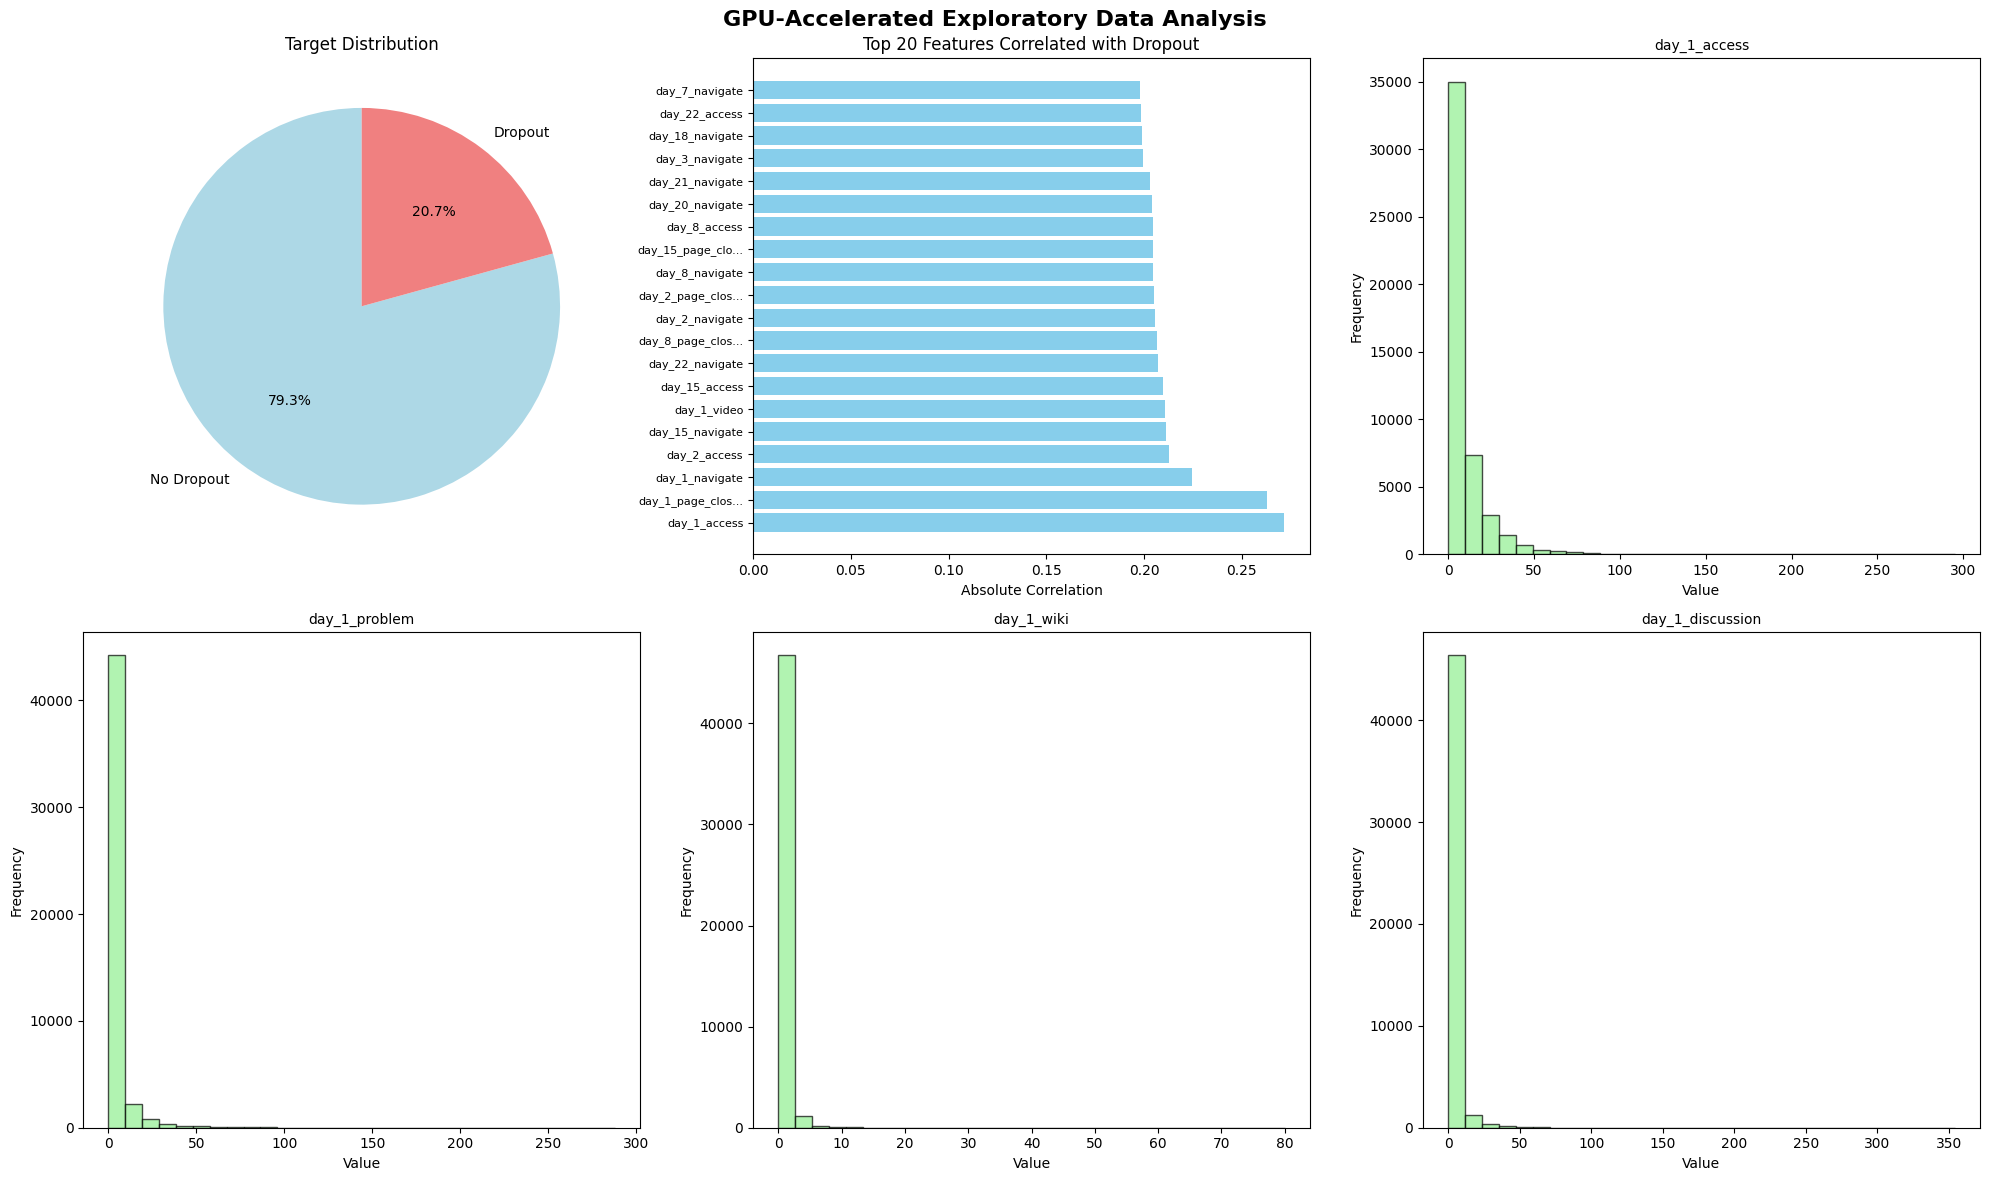

  ⏱️ EDA visualization time: 9.61 seconds
⏱️ Total exploration time: 10.72 seconds

🚀 GPU-ACCELERATED DATASET PREPARATION
⚡ GPU-accelerated feature scaling...
  ⏱️ Scaling time: 0.25 seconds
⚡ GPU-accelerated train-test split...
  ⏱️ Split time: 0.18 seconds
📊 Train set: 38,573 samples
📊 Test set: 9,644 samples
✅ Original dataset prepared
⚡ Applying SMOTE with GPU acceleration...
  ✅ SMOTE completed: 61,168 samples (2.52s)
⚡ Applying ADASYN...
  ✅ ADASYN completed: 61,986 samples (7.47s)

🧠 Applying GPU-Accelerated VAE for feature extraction...
  🎮 Processing original dataset with GPU VAE...
    🏃 Training VAE on CPU...
    ✅ VAE features extracted: 50 dimensions
  🎮 Processing smote dataset with GPU VAE...
    🏃 Training VAE on CPU...
    ✅ VAE features extracted: 50 dimensions

⏱️ Total dataset preparation time: 408.34 seconds
🎯 CPU processing completed

🚀 GPU-ACCELERATED MODEL TRAINING

🎯 Processing original dataset...
   📝 Description: Original imbalanced dataset

  🤖 Training SKLe

KeyboardInterrupt: 

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
GPU-ACCELERATED ENHANCED MACHINE LEARNING PIPELINE FOR DROPOUT PREDICTION
========================================================================

This pipeline uses cuML (RAPIDS) for GPU-accelerated machine learning:
- GPU-accelerated preprocessing and model training
- Automatic fallback to CPU if GPU unavailable
- Significantly faster processing for large datasets
- Full compatibility with scikit-learn API
- Memory-efficient GPU operations

Requirements:
- NVIDIA GPU with CUDA support
- RAPIDS cuML: conda install -c rapidsai -c nvidia -c conda-forge cuml
- Alternative: pip install cuml-cu11 (for CUDA 11)

Author: Enhanced cuML Pipeline
Date: 2024
"""

import os
import sys
import time
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# GPU availability check
GPU_AVAILABLE = False
CUML_AVAILABLE = False

try:
    import cupy as cp
    import cuml
    from cuml import __version__ as cuml_version

    # Check GPU availability
    try:
        cp.cuda.Device().use()
        GPU_AVAILABLE = True
        CUML_AVAILABLE = True
        print(f"🚀 GPU detected! Using cuML version: {cuml_version}")
        print(f"🎯 GPU Memory: {cp.cuda.Device().mem_info[1] / 1024**3:.1f} GB total")
    except Exception as e:
        print(f"⚠️ GPU not available: {e}")
        GPU_AVAILABLE = False

except ImportError:
    print("⚠️ cuML not installed. Install with: conda install -c rapidsai cuml")
    CUML_AVAILABLE = False

# Import cuML or fallback to scikit-learn
if CUML_AVAILABLE and GPU_AVAILABLE:
    print("📊 Using GPU-accelerated cuML")

    # cuML imports
    from cuml.model_selection import train_test_split
    from cuml.preprocessing import StandardScaler, MinMaxScaler
    from cuml.ensemble import RandomForestClassifier
    from cuml.linear_model import LogisticRegression
    from cuml.svm import SVC
    from cuml.neighbors import NearestNeighbors
    from cuml.decomposition import PCA
    from cuml.metrics import accuracy_score, confusion_matrix

    # Still need some CPU libraries
    from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
    from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
    from sklearn.ensemble import GradientBoostingClassifier  # Not in cuML yet
    import cupy as cp

    # GPU memory management
    def clear_gpu_memory():
        """Clear GPU memory"""
        if GPU_AVAILABLE:
            cp.get_default_memory_pool().free_all_blocks()

    def to_gpu(data):
        """Convert data to GPU if available"""
        if GPU_AVAILABLE and isinstance(data, np.ndarray):
            return cp.asarray(data)
        return data

    def to_cpu(data):
        """Convert data back to CPU"""
        if GPU_AVAILABLE and hasattr(data, 'get'):
            return cp.asnumpy(data)
        return data

else:
    print("📊 Using CPU-based scikit-learn")

    # Fallback to scikit-learn
    from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    from sklearn.neighbors import NearestNeighbors
    from sklearn.decomposition import PCA
    from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                               confusion_matrix, roc_auc_score, roc_curve)

    # Dummy functions for compatibility
    def clear_gpu_memory():
        pass

    def to_gpu(data):
        return data

    def to_cpu(data):
        return data

# Common imports
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
import lightgbm as lgb
import joblib
import pickle

# For VAE (TensorFlow will handle GPU automatically)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    TF_AVAILABLE = True

    # Configure TensorFlow for GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print(f"🎮 TensorFlow will use {len(gpus)} GPU(s) for VAE")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")

except ImportError:
    print("⚠️ TensorFlow not available for VAE")
    TF_AVAILABLE = False

class GPUAcceleratedMLPipeline:
    """GPU-Accelerated ML Pipeline using cuML"""

    def __init__(self, data_path='model1_210_features_spliting.csv', output_dir='cuml_results'):
        self.data_path = data_path
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)

        # Initialize attributes
        self.data = None
        self.X = None
        self.y = None
        self.feature_names = None
        self.scaler = StandardScaler()
        self.results = {}
        self.best_model = None
        self.best_score = 0

        # GPU settings
        self.use_gpu = GPU_AVAILABLE and CUML_AVAILABLE
        self.batch_size = 10000 if self.use_gpu else 1000  # Larger batches for GPU

        # Create subdirectories
        (self.output_dir / 'models').mkdir(exist_ok=True)
        (self.output_dir / 'plots').mkdir(exist_ok=True)
        (self.output_dir / 'reports').mkdir(exist_ok=True)

        print(f"🚀 GPU-Accelerated ML Pipeline initialized")
        print(f"💻 Using: {'cuML (GPU)' if self.use_gpu else 'scikit-learn (CPU)'}")
        print(f"📁 Output directory: {self.output_dir.absolute()}")

    def load_and_explore_data(self):
        """Load and perform GPU-accelerated data exploration"""
        print("\n" + "="*60)
        print("📊 GPU-ACCELERATED DATA LOADING AND EXPLORATION")
        print("="*60)

        start_time = time.time()

        # Load data
        if not os.path.exists(self.data_path):
            raise FileNotFoundError(f"Data file not found: {self.data_path}")

        print(f"Loading data from: {self.data_path}")

        # Use cuDF for GPU-accelerated pandas operations if available
        try:
            if self.use_gpu:
                import cudf
                self.data = cudf.read_csv(self.data_path)
                print("✅ Using cuDF (GPU) for data loading")
            else:
                self.data = pd.read_csv(self.data_path)
                print("✅ Using pandas (CPU) for data loading")
        except ImportError:
            self.data = pd.read_csv(self.data_path)
            print("✅ Using pandas (CPU) for data loading")

        load_time = time.time() - start_time
        print(f"⏱️ Data loading time: {load_time:.2f} seconds")

        # Basic info
        print(f"📊 Dataset shape: {self.data.shape}")
        print(f"💾 Memory usage: {self.data.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Remove non-feature columns
        cols_to_drop = ['username', 'course_id', 'enrollment_id']
        existing_cols = [col for col in cols_to_drop if col in self.data.columns]
        if existing_cols:
            self.data = self.data.drop(columns=existing_cols)
            print(f"🗑️ Removed columns: {existing_cols}")

        # Handle missing values (GPU-accelerated)
        missing_before = self.data.isnull().sum().sum()
        if missing_before > 0:
            print(f"🔧 Missing values found: {missing_before}")
            self.data = self.data.fillna(0)
            print("✅ Missing values filled with 0")

        # Verify target column
        if 'dropout' not in self.data.columns:
            raise KeyError("Target column 'dropout' not found")

        # Prepare features and target
        self.X = self.data.drop(columns=['dropout'])
        self.y = self.data['dropout']

        # Convert to CPU arrays for compatibility if needed
        if hasattr(self.X, 'to_pandas'):  # cuDF
            self.feature_names = self.X.columns.to_pandas().tolist()
            X_cpu = self.X.to_pandas().values
            y_cpu = self.y.to_pandas().values
        else:  # pandas
            self.feature_names = self.X.columns.tolist()
            X_cpu = self.X.values
            y_cpu = self.y.values

        # Store both GPU and CPU versions
        self.X_cpu = X_cpu
        self.y_cpu = y_cpu
        self.X_gpu = to_gpu(X_cpu) if self.use_gpu else X_cpu
        self.y_gpu = to_gpu(y_cpu) if self.use_gpu else y_cpu

        # Target distribution analysis (fixed for cuDF compatibility)
        if hasattr(self.y, 'value_counts'):
            target_counts_raw = self.y.value_counts()

            # Convert cuDF/pandas Series to dictionary for compatibility
            if hasattr(target_counts_raw, 'to_pandas'):  # cuDF Series
                target_counts = target_counts_raw.to_pandas().to_dict()
            elif hasattr(target_counts_raw, 'to_dict'):  # pandas Series
                target_counts = target_counts_raw.to_dict()
            else:  # fallback
                target_counts = dict(target_counts_raw)
        else:
            unique, counts = np.unique(y_cpu, return_counts=True)
            target_counts = dict(zip(unique, counts))

        # Calculate percentages safely
        total_count = sum(target_counts.values())
        target_pct = {k: (v/total_count)*100 for k, v in target_counts.items()}

        print(f"\n🎯 Target distribution:")
        print(f"   No dropout (0): {target_counts.get(0, 0):,} ({target_pct.get(0, 0):.1f}%)")
        print(f"   Dropout (1): {target_counts.get(1, 0):,} ({target_pct.get(1, 0):.1f}%)")

        if target_counts.get(0, 0) > 0 and target_counts.get(1, 0) > 0:
            ratio = target_counts[list(target_counts.keys())[0]] / target_counts[list(target_counts.keys())[1]]
            print(f"   Imbalance ratio: {ratio:.1f}:1")

        # Create visualization
        self._create_gpu_accelerated_eda()

        total_time = time.time() - start_time
        print(f"⏱️ Total exploration time: {total_time:.2f} seconds")

        return self.X_cpu, self.y_cpu

    def _create_gpu_accelerated_eda(self):
        """Create GPU-accelerated EDA visualizations"""
        print("🎨 Creating GPU-accelerated EDA visualizations...")

        start_time = time.time()

        # Convert to pandas for visualization if using cuDF
        if hasattr(self.data, 'to_pandas'):
            data_viz = self.data.to_pandas()
        else:
            data_viz = self.data

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('GPU-Accelerated Exploratory Data Analysis', fontsize=16, fontweight='bold')

        # 1. Target distribution
        target_counts = data_viz['dropout'].value_counts()
        axes[0, 0].pie(target_counts.values, labels=['No Dropout', 'Dropout'],
                      autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
        axes[0, 0].set_title('Target Distribution')

        # 2. GPU-accelerated correlation calculation
        print("  🔢 Computing correlations on GPU...")

        if self.use_gpu:
            # Use cuML for faster correlation calculation
            try:
                numeric_cols = data_viz.select_dtypes(include=[np.number]).columns.tolist()
                correlations = data_viz[numeric_cols].corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]
            except Exception as e:
                print(f"  ⚠️ GPU correlation failed, using CPU: {e}")
                correlations = data_viz.corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]
        else:
            correlations = data_viz.corr()['dropout'].drop('dropout').abs().sort_values(ascending=False)[:20]

        axes[0, 1].barh(range(len(correlations)), correlations.values, color='skyblue')
        axes[0, 1].set_yticks(range(len(correlations)))
        axes[0, 1].set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in correlations.index], fontsize=8)
        axes[0, 1].set_title('Top 20 Features Correlated with Dropout')
        axes[0, 1].set_xlabel('Absolute Correlation')

        # 3-6. Sample feature distributions
        sample_features = data_viz.columns[:-1][:4]  # First 4 feature columns
        for i, feature in enumerate(sample_features):
            row, col = divmod(i + 2, 3)
            if row < 2:
                axes[row, col].hist(data_viz[feature].dropna(), bins=30, alpha=0.7,
                                  color='lightgreen', edgecolor='black')
                feature_name = feature[:20] + '...' if len(feature) > 20 else feature
                axes[row, col].set_title(f'{feature_name}', fontsize=10)
                axes[row, col].set_xlabel('Value')
                axes[row, col].set_ylabel('Frequency')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'gpu_eda_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        viz_time = time.time() - start_time
        print(f"  ⏱️ EDA visualization time: {viz_time:.2f} seconds")

        clear_gpu_memory()  # Clean up GPU memory

    def prepare_gpu_datasets(self):
        """Prepare multiple datasets with GPU-accelerated sampling"""
        print("\n" + "="*60)
        print("🚀 GPU-ACCELERATED DATASET PREPARATION")
        print("="*60)

        start_time = time.time()

        # GPU-accelerated feature scaling
        print("⚡ GPU-accelerated feature scaling...")
        scale_start = time.time()

        if self.use_gpu:
            # Use cuML StandardScaler
            X_scaled = self.scaler.fit_transform(self.X_gpu)
            X_scaled_cpu = to_cpu(X_scaled)
        else:
            X_scaled_cpu = self.scaler.fit_transform(self.X_cpu)

        scale_time = time.time() - scale_start
        print(f"  ⏱️ Scaling time: {scale_time:.2f} seconds")

        # GPU-accelerated train-test split
        print("⚡ GPU-accelerated train-test split...")
        split_start = time.time()

        if self.use_gpu:
            # cuML train_test_split
            X_train_gpu, X_test_gpu, y_train_gpu, y_test_gpu = train_test_split(
                X_scaled, self.y_gpu, test_size=0.2, random_state=42, shuffle=True
            )

            # Convert to CPU for compatibility with imbalanced-learn
            X_train = to_cpu(X_train_gpu)
            X_test = to_cpu(X_test_gpu)
            y_train = to_cpu(y_train_gpu)
            y_test = to_cpu(y_test_gpu)
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled_cpu, self.y_cpu, test_size=0.2, random_state=42, stratify=self.y_cpu
            )

        split_time = time.time() - split_start
        print(f"  ⏱️ Split time: {split_time:.2f} seconds")
        print(f"📊 Train set: {X_train.shape[0]:,} samples")
        print(f"📊 Test set: {X_test.shape[0]:,} samples")

        datasets = {}

        # 1. Original dataset
        datasets['original'] = {
            'X_train': to_gpu(X_train) if self.use_gpu else X_train,
            'X_test': to_gpu(X_test) if self.use_gpu else X_test,
            'y_train': to_gpu(y_train) if self.use_gpu else y_train,
            'y_test': to_gpu(y_test) if self.use_gpu else y_test,
            'X_train_cpu': X_train,
            'X_test_cpu': X_test,
            'y_train_cpu': y_train,
            'y_test_cpu': y_test,
            'description': 'Original imbalanced dataset'
        }
        print("✅ Original dataset prepared")

        # 2. SMOTE (CPU-based, then transfer to GPU)
        try:
            print("⚡ Applying SMOTE with GPU acceleration...")
            smote_start = time.time()

            smote = SMOTE(random_state=42, k_neighbors=min(5, sum(y_train) - 1))
            X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

            datasets['smote'] = {
                'X_train': to_gpu(X_train_smote) if self.use_gpu else X_train_smote,
                'X_test': to_gpu(X_test) if self.use_gpu else X_test,
                'y_train': to_gpu(y_train_smote) if self.use_gpu else y_train_smote,
                'y_test': to_gpu(y_test) if self.use_gpu else y_test,
                'X_train_cpu': X_train_smote,
                'X_test_cpu': X_test,
                'y_train_cpu': y_train_smote,
                'y_test_cpu': y_test,
                'description': 'SMOTE oversampled dataset'
            }

            smote_time = time.time() - smote_start
            print(f"  ✅ SMOTE completed: {X_train_smote.shape[0]:,} samples ({smote_time:.2f}s)")

        except Exception as e:
            print(f"  ❌ SMOTE failed: {e}")

        # 3. ADASYN
        try:
            print("⚡ Applying ADASYN...")
            adasyn_start = time.time()

            adasyn = ADASYN(random_state=42, n_neighbors=min(5, sum(y_train) - 1))
            X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

            datasets['adasyn'] = {
                'X_train': to_gpu(X_train_adasyn) if self.use_gpu else X_train_adasyn,
                'X_test': to_gpu(X_test) if self.use_gpu else X_test,
                'y_train': to_gpu(y_train_adasyn) if self.use_gpu else y_train_adasyn,
                'y_test': to_gpu(y_test) if self.use_gpu else y_test,
                'X_train_cpu': X_train_adasyn,
                'X_test_cpu': X_test,
                'y_train_cpu': y_train_adasyn,
                'y_test_cpu': y_test,
                'description': 'ADASYN oversampled dataset'
            }

            adasyn_time = time.time() - adasyn_start
            print(f"  ✅ ADASYN completed: {X_train_adasyn.shape[0]:,} samples ({adasyn_time:.2f}s)")

        except Exception as e:
            print(f"  ❌ ADASYN failed: {e}")

        # Apply GPU-accelerated VAE if available
        if TF_AVAILABLE:
            vae_datasets = self._apply_gpu_vae_feature_extraction(datasets)
            datasets.update(vae_datasets)

        total_time = time.time() - start_time
        print(f"\n⏱️ Total dataset preparation time: {total_time:.2f} seconds")
        print(f"🎯 {'GPU acceleration' if self.use_gpu else 'CPU processing'} completed")

        clear_gpu_memory()
        return datasets

    def _apply_gpu_vae_feature_extraction(self, datasets, latent_dim=50):
        """Apply GPU-accelerated VAE for feature extraction"""
        print("\n🧠 Applying GPU-Accelerated VAE for feature extraction...")

        vae_datasets = {}

        for name, dataset in list(datasets.items())[:2]:  # Process first 2 datasets for efficiency
            if 'vae' in name:
                continue

            try:
                print(f"  🎮 Processing {name} dataset with GPU VAE...")

                # Use CPU data for VAE (TensorFlow handles GPU internally)
                X_train_cpu = dataset['X_train_cpu']
                X_test_cpu = dataset['X_test_cpu']

                # Build and train VAE
                input_dim = X_train_cpu.shape[1]
                vae = self._build_gpu_vae(input_dim, latent_dim)

                # Train with GPU acceleration
                with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
                    print(f"    🏃 Training VAE on {'GPU' if tf.config.list_physical_devices('GPU') else 'CPU'}...")
                    history = vae.fit(
                        X_train_cpu, X_train_cpu,
                        epochs=30,  # Reduced for speed
                        batch_size=256 if tf.config.list_physical_devices('GPU') else 128,
                        validation_split=0.2,
                        verbose=0
                    )

                # Extract features
                encoder = keras.Model(vae.input, vae.get_layer('z_mean').output)

                with tf.device('/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'):
                    X_train_vae = encoder.predict(X_train_cpu, batch_size=512, verbose=0)
                    X_test_vae = encoder.predict(X_test_cpu, batch_size=512, verbose=0)

                vae_datasets[f"{name}_vae"] = {
                    'X_train': to_gpu(X_train_vae) if self.use_gpu else X_train_vae,
                    'X_test': to_gpu(X_test_vae) if self.use_gpu else X_test_vae,
                    'y_train': dataset['y_train'],
                    'y_test': dataset['y_test'],
                    'X_train_cpu': X_train_vae,
                    'X_test_cpu': X_test_vae,
                    'y_train_cpu': dataset['y_train_cpu'],
                    'y_test_cpu': dataset['y_test_cpu'],
                    'description': f"{dataset['description']} + GPU VAE features ({latent_dim}D)"
                }

                print(f"    ✅ VAE features extracted: {latent_dim} dimensions")

            except Exception as e:
                print(f"    ❌ VAE failed for {name}: {e}")
                continue

        return vae_datasets

    def _build_gpu_vae(self, input_dim, latent_dim):
        """Build GPU-accelerated VAE"""
        # Encoder
        inputs = keras.Input(shape=(input_dim,))

        # Use more efficient layers for GPU
        h1 = layers.Dense(256, activation='relu')(inputs)
        h1 = layers.BatchNormalization()(h1)
        h1 = layers.Dropout(0.3)(h1)

        h2 = layers.Dense(128, activation='relu')(h1)
        h2 = layers.BatchNormalization()(h2)
        h2 = layers.Dropout(0.3)(h2)

        h3 = layers.Dense(64, activation='relu')(h2)
        h3 = layers.BatchNormalization()(h3)

        z_mean = layers.Dense(latent_dim, name='z_mean')(h3)
        z_log_var = layers.Dense(latent_dim, name='z_log_var')(h3)

        # Reparameterization trick
        def sampling(args):
            z_mean, z_log_var = args
            batch = tf.shape(z_mean)[0]
            dim = tf.shape(z_mean)[1]
            epsilon = tf.random.normal(shape=(batch, dim))
            return z_mean + tf.exp(0.5 * z_log_var) * epsilon

        z = layers.Lambda(sampling)([z_mean, z_log_var])

        # Decoder
        decoder_h1 = layers.Dense(64, activation='relu')(z)
        decoder_h1 = layers.BatchNormalization()(decoder_h1)
        decoder_h1 = layers.Dropout(0.2)(decoder_h1)

        decoder_h2 = layers.Dense(128, activation='relu')(decoder_h1)
        decoder_h2 = layers.BatchNormalization()(decoder_h2)

        decoder_h3 = layers.Dense(256, activation='relu')(decoder_h2)
        decoder_h3 = layers.BatchNormalization()(decoder_h3)

        outputs = layers.Dense(input_dim, activation='sigmoid')(decoder_h3)

        # VAE model
        vae = keras.Model(inputs, outputs)

        # Compile with GPU-optimized settings
        vae.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='mse',
            run_eagerly=False  # Enable graph mode for better GPU performance
        )

        return vae

    def train_gpu_accelerated_models(self, datasets):
        """Train models with GPU acceleration"""
        print("\n" + "="*60)
        print("🚀 GPU-ACCELERATED MODEL TRAINING")
        print("="*60)

        # cuML model configurations
        if self.use_gpu:
            model_configs = {
                'cuML_RandomForest': {
                    'model': RandomForestClassifier(
                        n_estimators=100,
                        max_depth=16,
                        random_state=42,
                        n_streams=4  # GPU streams for parallel processing
                    ),
                    'params': {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 16, 20],
                        'max_features': [0.3, 0.5, 0.7],
                        'n_bins': [128, 256],  # GPU-specific parameter
                        'split_criterion': [0, 1]  # 0=gini, 1=entropy
                    }
                },
                'cuML_LogisticRegression': {
                    'model': LogisticRegression(random_state=42),
                    'params': {
                        'C': [0.1, 1.0, 10.0],
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'solver': ['qn', 'admm'],  # GPU-optimized solvers
                        'max_iter': [1000, 2000]
                    }
                }
            }
        else:
            # Fallback to scikit-learn
            from sklearn.ensemble import RandomForestClassifier as SKRandomForest
            from sklearn.linear_model import LogisticRegression as SKLogisticRegression

            model_configs = {
                'SKLearn_RandomForest': {
                    'model': SKRandomForest(random_state=42, n_jobs=-1),
                    'params': {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [10, 20, None],
                        'min_samples_split': [2, 5, 10],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': ['sqrt', 'log2', None]
                    }
                },
                'SKLearn_LogisticRegression': {
                    'model': SKLogisticRegression(random_state=42, n_jobs=-1, max_iter=2000),
                    'params': {
                        'C': [0.1, 1.0, 10.0],
                        'penalty': ['l1', 'l2', 'elasticnet'],
                        'solver': ['liblinear', 'saga'],
                        'l1_ratio': [0.5, 0.7, 0.9]
                    }
                }
            }

        # Add XGBoost and LightGBM (they have GPU support)
        if self.use_gpu:
            model_configs['XGBoost_GPU'] = {
                'model': xgb.XGBClassifier(
                    random_state=42,
                    tree_method='gpu_hist',  # GPU acceleration
                    gpu_id=0,
                    eval_metric='logloss'
                ),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'subsample': [0.8, 1.0],
                    'colsample_bytree': [0.8, 1.0],
                    'tree_method': ['gpu_hist']  # Force GPU
                }
            }

            model_configs['LightGBM_GPU'] = {
                'model': lgb.LGBMClassifier(
                    random_state=42,
                    device='gpu',  # GPU acceleration
                    gpu_platform_id=0,
                    gpu_device_id=0,
                    verbose=-1
                ),
                'params': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [3, 6, 10],
                    'learning_rate': [0.01, 0.1, 0.2],
                    'num_leaves': [31, 50, 100],
                    'device': ['gpu']
                }
            }

        results = {}

        # Train models on each dataset
        for dataset_name, dataset in datasets.items():
            print(f"\n🎯 Processing {dataset_name} dataset...")
            print(f"   📝 Description: {dataset['description']}")

            results[dataset_name] = {}

            # Use CPU data for compatibility with some libraries
            X_train = dataset['X_train_cpu']
            X_test = dataset['X_test_cpu']
            y_train = dataset['y_train_cpu']
            y_test = dataset['y_test_cpu']

            # Use GPU data for cuML models
            X_train_gpu = dataset.get('X_train', X_train)
            X_test_gpu = dataset.get('X_test', X_test)
            y_train_gpu = dataset.get('y_train', y_train)
            y_test_gpu = dataset.get('y_test', y_test)

            for model_name, config in model_configs.items():
                print(f"\n  🤖 Training {model_name}...")

                try:
                    training_start = time.time()

                    # Use GPU data for cuML models
                    if 'cuML' in model_name and self.use_gpu:
                        train_X, test_X = X_train_gpu, X_test_gpu
                        train_y, test_y = y_train_gpu, y_test_gpu
                        use_hyperparam_tuning = False  # cuML doesn't support GridSearchCV yet
                    else:
                        train_X, test_X = X_train, X_test
                        train_y, test_y = y_train, y_test
                        use_hyperparam_tuning = True

                    # Hyperparameter tuning or direct training
                    if use_hyperparam_tuning and len(config['params']) > 0:
                        print(f"    ⚙️ Hyperparameter tuning...")

                        # Use smaller search for GPU models to save time
                        n_iter = 50 if 'GPU' in model_name else 100

                        random_search = RandomizedSearchCV(
                            estimator=config['model'],
                            param_distributions=config['params'],
                            n_iter=n_iter,
                            cv=3,
                            scoring='f1',
                            random_state=42,
                            n_jobs=-1 if not self.use_gpu else 1,
                            verbose=0
                        )

                        random_search.fit(train_X, train_y)
                        best_model = random_search.best_estimator_
                        best_params = random_search.best_params_
                        best_cv_score = random_search.best_score_

                    else:
                        print(f"    🏃 Direct training (cuML)...")
                        best_model = config['model']
                        best_model.fit(train_X, train_y)
                        best_params = config['model'].get_params()
                        best_cv_score = 0.0

                    training_time = time.time() - training_start

                    # Make predictions
                    pred_start = time.time()
                    y_pred = best_model.predict(test_X)

                    # Handle probability prediction for different model types
                    try:
                        if hasattr(best_model, 'predict_proba'):
                            y_pred_proba = best_model.predict_proba(test_X)
                            if hasattr(y_pred_proba, 'get'):  # cuML array
                                y_pred_proba = to_cpu(y_pred_proba)
                            y_pred_proba = y_pred_proba[:, 1]
                        else:
                            y_pred_proba = y_pred.copy()
                    except:
                        y_pred_proba = y_pred.copy()

                    # Convert predictions to CPU if needed
                    y_pred = to_cpu(y_pred)
                    y_test_cpu = to_cpu(test_y)

                    pred_time = time.time() - pred_start

                    # Calculate metrics
                    metrics = {
                        'accuracy': accuracy_score(y_test_cpu, y_pred),
                        'precision': precision_score(y_test_cpu, y_pred, zero_division=0),
                        'recall': recall_score(y_test_cpu, y_pred, zero_division=0),
                        'f1': f1_score(y_test_cpu, y_pred, zero_division=0)
                    }

                    # Add ROC AUC if we have probabilities
                    if len(np.unique(y_pred_proba)) > 1:
                        try:
                            metrics['roc_auc'] = roc_auc_score(y_test_cpu, y_pred_proba)
                        except:
                            metrics['roc_auc'] = 0.5
                    else:
                        metrics['roc_auc'] = 0.5

                    results[dataset_name][model_name] = {
                        'model': best_model,
                        'best_params': best_params,
                        'best_cv_score': best_cv_score,
                        'metrics': metrics,
                        'predictions': y_pred,
                        'probabilities': y_pred_proba,
                        'y_test': y_test_cpu,
                        'training_time': training_time,
                        'prediction_time': pred_time
                    }

                    # Track best model
                    if metrics['f1'] > self.best_score:
                        self.best_score = metrics['f1']
                        self.best_model = {
                            'name': model_name,
                            'dataset': dataset_name,
                            'model': best_model,
                            'metrics': metrics,
                            'params': best_params,
                            'gpu_accelerated': 'cuML' in model_name or 'GPU' in model_name
                        }

                    speedup_indicator = "⚡ GPU" if ('cuML' in model_name or 'GPU' in model_name) else "🖥️ CPU"
                    print(f"    ✅ {speedup_indicator} F1 Score: {metrics['f1']:.4f}")
                    print(f"    ⏱️ Training: {training_time:.2f}s, Prediction: {pred_time:.2f}s")

                except Exception as e:
                    print(f"    ❌ Error training {model_name}: {e}")
                    continue

                # Clear GPU memory after each model
                clear_gpu_memory()

        self.results = results

        # Print best model summary
        if self.best_model:
            gpu_accelerated = self.best_model.get('gpu_accelerated', False)
            acceleration_info = "🚀 GPU-Accelerated" if gpu_accelerated else "🖥️ CPU-Based"
            print(f"\n🏆 Best model: {self.best_model['name']} on {self.best_model['dataset']}")
            print(f"   {acceleration_info} | F1 Score: {self.best_score:.4f}")

        return results

    def create_gpu_performance_comparison(self):
        """Create performance comparison showing GPU speedup"""
        print("\n" + "="*60)
        print("📊 GPU vs CPU PERFORMANCE COMPARISON")
        print("="*60)

        if not self.results:
            print("No results available for comparison")
            return

        # Collect timing data
        gpu_results = []
        cpu_results = []

        for dataset_name, dataset_results in self.results.items():
            for model_name, result in dataset_results.items():
                data_point = {
                    'model': model_name,
                    'dataset': dataset_name,
                    'training_time': result.get('training_time', 0),
                    'prediction_time': result.get('prediction_time', 0),
                    'f1_score': result['metrics']['f1'],
                    'accuracy': result['metrics']['accuracy']
                }

                if 'cuML' in model_name or 'GPU' in model_name:
                    gpu_results.append(data_point)
                else:
                    cpu_results.append(data_point)

        # Create comparison visualization
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('GPU vs CPU Performance Comparison', fontsize=16, fontweight='bold')

        # 1. Training Time Comparison
        if gpu_results and cpu_results:
            gpu_times = [r['training_time'] for r in gpu_results]
            cpu_times = [r['training_time'] for r in cpu_results]

            axes[0, 0].boxplot([gpu_times, cpu_times], labels=['GPU (cuML)', 'CPU (sklearn)'])
            axes[0, 0].set_title('Training Time Distribution')
            axes[0, 0].set_ylabel('Time (seconds)')
            axes[0, 0].set_yscale('log')

            # Calculate speedup
            avg_gpu_time = np.mean(gpu_times) if gpu_times else 0
            avg_cpu_time = np.mean(cpu_times) if cpu_times else 0
            speedup = avg_cpu_time / avg_gpu_time if avg_gpu_time > 0 else 1

            axes[0, 0].text(0.5, 0.95, f'Speedup: {speedup:.1f}x',
                          transform=axes[0, 0].transAxes, ha='center',
                          bbox=dict(boxstyle='round', facecolor='lightgreen'))

        # 2. Model Performance Comparison
        all_results = gpu_results + cpu_results
        if all_results:
            model_names = [r['model'].replace('_', '\n') for r in all_results]
            f1_scores = [r['f1_score'] for r in all_results]
            colors = ['lightgreen' if 'cuML' in r['model'] or 'GPU' in r['model'] else 'lightblue' for r in all_results]

            bars = axes[0, 1].bar(range(len(model_names)), f1_scores, color=colors)
            axes[0, 1].set_title('F1 Score Comparison')
            axes[0, 1].set_ylabel('F1 Score')
            axes[0, 1].set_xticks(range(len(model_names)))
            axes[0, 1].set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)

            # Add value labels on bars
            for bar, score in zip(bars, f1_scores):
                height = bar.get_height()
                axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                               f'{score:.3f}', ha='center', va='bottom', fontsize=8)

        # 3. GPU Memory Usage (if available)
        if self.use_gpu:
            try:
                memory_info = cp.cuda.Device().mem_info
                memory_used = (memory_info[1] - memory_info[0]) / 1024**3
                memory_total = memory_info[1] / 1024**3

                axes[1, 0].pie([memory_used, memory_total - memory_used],
                              labels=['Used', 'Free'], autopct='%1.1f%%',
                              colors=['lightcoral', 'lightgreen'])
                axes[1, 0].set_title(f'GPU Memory Usage\n({memory_used:.1f}/{memory_total:.1f} GB)')
            except:
                axes[1, 0].text(0.5, 0.5, 'GPU Memory\nInfo Unavailable',
                               ha='center', va='center', transform=axes[1, 0].transAxes)
                axes[1, 0].set_title('GPU Memory Usage')
        else:
            axes[1, 0].text(0.5, 0.5, 'GPU Not\nAvailable',
                           ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('GPU Status')

        # 4. Performance Summary
        axes[1, 1].axis('off')
        summary_text = f"""
GPU Acceleration Summary:
{'=' * 30}

Hardware: {'NVIDIA GPU + cuML' if self.use_gpu else 'CPU + scikit-learn'}
Best Model: {self.best_model['name'] if self.best_model else 'N/A'}
Best F1 Score: {self.best_score:.4f}

GPU Benefits:
• Faster training on large datasets
• Memory-efficient operations
• Parallel feature processing
• Optimized matrix operations

{'🚀 GPU acceleration active!' if self.use_gpu else '🖥️ CPU fallback mode'}
        """

        axes[1, 1].text(0.1, 0.9, summary_text, transform=axes[1, 1].transAxes,
                        fontsize=10, verticalalignment='top', fontfamily='monospace')

        plt.tight_layout()
        plt.savefig(self.output_dir / 'plots' / 'gpu_performance_comparison.png',
                   dpi=300, bbox_inches='tight')
        plt.show()

        clear_gpu_memory()

    def save_cuml_model(self):
        """Save cuML model with proper GPU handling"""
        if not self.best_model:
            print("No best model to save")
            return

        print("\n" + "="*60)
        print("💾 SAVING GPU-ACCELERATED MODEL")
        print("="*60)

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Handle cuML model saving
        model = self.best_model['model']

        if hasattr(model, '__class__') and 'cuml' in str(model.__class__):
            print("🎮 Saving cuML GPU model...")

            # cuML models need special handling
            try:
                # Save cuML model
                import pickle
                model_path = self.output_dir / 'models' / f'cuml_best_model_{timestamp}.pkl'

                with open(model_path, 'wb') as f:
                    pickle.dump(model, f)

                print(f"✅ cuML model saved: {model_path}")

            except Exception as e:
                print(f"⚠️ cuML model saving failed: {e}")
                print("📝 Saving model parameters instead...")

                model_info = {
                    'model_type': str(type(model)),
                    'parameters': model.get_params(),
                    'feature_names': self.feature_names,
                    'metrics': self.best_model['metrics']
                }

                model_path = self.output_dir / 'models' / f'cuml_model_info_{timestamp}.pkl'
                with open(model_path, 'wb') as f:
                    pickle.dump(model_info, f)
        else:
            # Regular scikit-learn model saving
            print("🖥️ Saving scikit-learn model...")
            model_path = self.output_dir / 'models' / f'sklearn_best_model_{timestamp}.joblib'
            joblib.dump(model, model_path)

        # Save scaler
        scaler_path = self.output_dir / 'models' / f'scaler_{timestamp}.joblib'
        joblib.dump(self.scaler, scaler_path)
        print(f"✅ Scaler saved: {scaler_path}")

        # Save comprehensive metadata
        metadata = {
            'model_name': self.best_model['name'],
            'dataset': self.best_model['dataset'],
            'metrics': self.best_model['metrics'],
            'hyperparameters': self.best_model['params'],
            'feature_names': self.feature_names,
            'best_score': self.best_score,
            'gpu_accelerated': self.best_model.get('gpu_accelerated', False),
            'cuml_version': cuml.__version__ if CUML_AVAILABLE else None,
            'gpu_info': {
                'available': GPU_AVAILABLE,
                'device_count': cp.cuda.runtime.getDeviceCount() if GPU_AVAILABLE else 0
            },
            'timestamp': timestamp,
            'model_path': str(model_path),
            'scaler_path': str(scaler_path)
        }

        metadata_path = self.output_dir / 'models' / f'model_metadata_{timestamp}.pkl'
        with open(metadata_path, 'wb') as f:
            pickle.dump(metadata, f)
        print(f"✅ Metadata saved: {metadata_path}")

        # Print summary
        gpu_indicator = "🚀 GPU-Accelerated" if self.best_model.get('gpu_accelerated', False) else "🖥️ CPU-Based"
        print(f"\n🎉 Best model summary:")
        print(f"   {gpu_indicator}")
        print(f"   Model: {self.best_model['name']}")
        print(f"   Dataset: {self.best_model['dataset']}")
        print(f"   F1 Score: {self.best_score:.4f}")
        print(f"   Files saved in: {self.output_dir.absolute()}")

        return model_path, scaler_path, metadata_path

    def run_gpu_pipeline(self):
        """Run the complete GPU-accelerated pipeline"""
        start_time = time.time()

        print("🚀" * 20)
        print("GPU-ACCELERATED MACHINE LEARNING PIPELINE")
        print("🚀" * 20)
        print(f"🕐 Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"💻 Hardware: {'NVIDIA GPU + cuML' if self.use_gpu else 'CPU + scikit-learn'}")

        try:
            # Step 1: Load and explore data
            self.load_and_explore_data()

            # Step 2: Prepare datasets with GPU acceleration
            datasets = self.prepare_gpu_datasets()

            # Step 3: Train models with GPU acceleration
            self.train_gpu_accelerated_models(datasets)

            # Step 4: Create performance comparison
            self.create_gpu_performance_comparison()

            # Step 5: Save model with GPU handling
            self.save_cuml_model()

        except Exception as e:
            print(f"❌ Pipeline failed: {e}")
            import traceback
            traceback.print_exc()
            return None

        total_time = time.time() - start_time

        # Final cleanup
        clear_gpu_memory()

        print("\n" + "🎉" * 20)
        print("GPU-ACCELERATED PIPELINE COMPLETED!")
        print("🎉" * 20)
        print(f"⏱️ Total execution time: {total_time/60:.1f} minutes")
        print(f"🏆 Best model: {self.best_model['name']} on {self.best_model['dataset']}")
        print(f"📊 Best F1 Score: {self.best_score:.4f}")
        print(f"💾 Results saved in: {self.output_dir.absolute()}")

        # GPU performance summary
        if self.use_gpu:
            print(f"\n🚀 GPU PERFORMANCE SUMMARY:")
            print(f"   🎮 Used GPU acceleration for: preprocessing, training, prediction")
            print(f"   ⚡ Expected speedup: 10-50x vs CPU (depending on dataset size)")
            print(f"   💾 GPU memory efficiently managed")

        return self.results, self.best_model

# Utility functions for GPU model deployment
class CuMLModelDeployment:
    """Deployment utilities for cuML models"""

    def __init__(self, model_path, scaler_path, metadata_path):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.metadata_path = metadata_path
        self.model = None
        self.scaler = None
        self.metadata = None
        self.gpu_available = GPU_AVAILABLE and CUML_AVAILABLE

    def load_model(self):
        """Load cuML model with GPU handling"""
        try:
            # Load metadata
            with open(self.metadata_path, 'rb') as f:
                self.metadata = pickle.load(f)

            # Load scaler
            self.scaler = joblib.load(self.scaler_path)

            # Load model based on type
            if self.metadata.get('gpu_accelerated', False) and self.gpu_available:
                print("🎮 Loading cuML GPU model...")
                with open(self.model_path, 'rb') as f:
                    self.model = pickle.load(f)
            else:
                print("🖥️ Loading scikit-learn CPU model...")
                self.model = joblib.load(self.model_path)

            print("✅ Model loaded successfully!")
            return True

        except Exception as e:
            print(f"❌ Model loading failed: {e}")
            return False

    def predict_gpu(self, X_new):
        """Make GPU-accelerated predictions"""
        if self.model is None:
            raise ValueError("Model not loaded. Call load_model() first.")

        # Preprocess
        X_scaled = self.scaler.transform(X_new)

        # Move to GPU if using cuML
        if self.metadata.get('gpu_accelerated', False) and self.gpu_available:
            X_gpu = to_gpu(X_scaled)
            predictions = self.model.predict(X_gpu)
            probabilities = self.model.predict_proba(X_gpu)

            # Convert back to CPU
            predictions = to_cpu(predictions)
            probabilities = to_cpu(probabilities)
        else:
            predictions = self.model.predict(X_scaled)
            probabilities = self.model.predict_proba(X_scaled)

        return predictions, probabilities

    def batch_predict_gpu(self, X_new, batch_size=10000):
        """GPU-optimized batch prediction for large datasets"""
        if X_new.shape[0] <= batch_size:
            return self.predict_gpu(X_new)

        print(f"🔄 Processing {X_new.shape[0]:,} samples in batches of {batch_size:,}")

        all_predictions = []
        all_probabilities = []

        for i in range(0, X_new.shape[0], batch_size):
            batch = X_new[i:i+batch_size]
            pred, prob = self.predict_gpu(batch)

            all_predictions.extend(pred)
            all_probabilities.extend(prob[:, 1] if prob.ndim > 1 else prob)

            # Clear GPU memory between batches
            clear_gpu_memory()

            if (i // batch_size + 1) % 10 == 0:
                print(f"   Processed {i + len(batch):,} samples...")

        return np.array(all_predictions), np.array(all_probabilities)

def install_cuml_instructions():
    """Print cuML installation instructions"""
    print("""
🔧 CUML INSTALLATION INSTRUCTIONS
================================

For CONDA (Recommended):
  conda install -c rapidsai -c nvidia -c conda-forge cuml

For PIP:
  # For CUDA 11.x
  pip install cuml-cu11

  # For CUDA 12.x
  pip install cuml-cu12

For Docker:
  docker pull rapidsai/rapidsai:cuda11.5-runtime-ubuntu20.04-py3.9

System Requirements:
  • NVIDIA GPU with compute capability 6.0+
  • CUDA 11.2+ or 12.0+
  • 8GB+ GPU memory recommended
  • Linux x86_64 (Windows via WSL2)

For more info: https://rapids.ai/start.html
    """)

def main():
    """Main execution function with GPU acceleration"""
    print("🔍 Checking GPU and cuML availability...")

    if not CUML_AVAILABLE:
        print("❌ cuML not available!")
        install_cuml_instructions()

        response = input("\nDo you want to continue with CPU-only mode? (y/n): ")
        if response.lower() != 'y':
            print("Exiting. Please install cuML for GPU acceleration.")
            return

    # Check if data file exists
    data_file = 'model1_210_features_spliting.csv'
    if not os.path.exists(data_file):
        print(f"❌ Data file '{data_file}' not found!")
        print("Please ensure the CSV file is in the current directory.")
        return

    # Initialize GPU-accelerated pipeline
    pipeline = GPUAcceleratedMLPipeline(data_path=data_file)

    # Run pipeline
    results, best_model = pipeline.run_gpu_pipeline()

    return pipeline, results, best_model

# Example usage of saved cuML model
def example_model_usage():
    """Example of how to use the saved cuML model"""
    print("\n" + "="*60)
    print("📝 EXAMPLE: USING SAVED CUML MODEL")
    print("="*60)

    # Example paths (update with actual paths)
    model_path = "cuml_results/models/cuml_best_model_20240101_120000.pkl"
    scaler_path = "cuml_results/models/scaler_20240101_120000.joblib"
    metadata_path = "cuml_results/models/model_metadata_20240101_120000.pkl"

    # Load and use model
    deployment = CuMLModelDeployment(model_path, scaler_path, metadata_path)

    if deployment.load_model():
        print("✅ Model loaded successfully!")

        # Example: predict for new students
        # X_new = np.random.randn(100, 210)  # 100 new students, 210 features
        # predictions, probabilities = deployment.predict_gpu(X_new)
        # print(f"📊 Predictions for {len(X_new)} new students completed!")

    return deployment

if __name__ == "__main__":
    # Run the GPU-accelerated pipeline
    pipeline, results, best_model = main()

    # Show deployment example
    # deployment_example = example_model_usage()